In [8]:
!pip3 install torchtext

  Using cached torchtext-0.13.1-cp310-cp310-win_amd64.whl (2.2 MB)
  Using cached requests-2.28.1-py3-none-any.whl (62 kB)
  Using cached tqdm-4.64.1-py2.py3-none-any.whl (78 kB)
  Using cached torch-1.12.1-cp310-cp310-win_amd64.whl (162.2 MB)
  Using cached certifi-2022.9.14-py3-none-any.whl (162 kB)


ERROR: Could not install packages due to an OSError: [WinError 2] The system cannot find the file specified: 'C:\\Python310\\Scripts\\tqdm.exe' -> 'C:\\Python310\\Scripts\\tqdm.exe.deleteme'



In [9]:
import os
import pickle

import numpy as np
import pandas as pd
import seaborn as sns


from matplotlib import pyplot as plt

# Setup

In [10]:
data_dir = os.path.join(os.curdir, "data")
os.listdir(data_dir)

['arsentd-lev',
 'ArSenTD-LEV.tsv',
 'arsentd-lev.zip',
 'char_tokenizer.pkl',
 'MNIST',
 'word_tokenizer.pkl']

## Data

In [11]:
#data_filepath = os.path.join(data_dir, "ArSenTD-LEV.tsv")
raw_dataset_url = "https://shai-nlp-course.netlify.app/clean-tweets.tsv"
raw = pd.read_csv(filepath_or_buffer=raw_dataset_url, sep="\t")

raw.head()

,Tweet,Country,Topic,Sentiment,Sentiment_Expression,Sentiment_Target,word_count,char_count,clean_text,clean_stemmed
0,"""أنا أؤمن بأن الانسان ينطفئ جماله عند ابتعاد م...",lebanon,personal,negative,implicit,بريق العيون,23,132,أؤمن بأن الانسان ينطفئ جماله ابتعاد يحب بريق ا...,اؤم بأن انس طفئ جمل بعد يحب برق عين خفي صبح ذب...
1,من الذاكره... @3FInQe . عندما اعتقد كريستيانو ...,jordan,sports,positive,explicit,افضل لاعب في العالم,23,141,الذاكره عندما اعتقد كريستيانو انه افضل لاعب ال...,ذكر عند عقد كريستيانو انه فضل لعب علم ككا يسي ...
2,لا نخلو من ضغوطات الحياة. فنحن نعيش على أرض أع...,palestine,personal,neutral,none,none,24,133,نخلو ضغوطات الحياة فنحن نعيش أرض أعدت للبلاء و...,خلو ضغط حية فنح نعش ارض اعد بلء ولم سلم بيء وك...
3,#مصطلحات_لبنانيه_حيرت_البشريه بتوصل عالبيت ، ب...,lebanon,personal,negative,explicit,مصطلحات_لبنانيه,23,135,بتوصل عالبيت بنط بقلك جيت بتقعد لتتحدث معو بقل...,وصل علب بنط بقل جيت قعد حدث معو بقل شو تقم تمش...
4,نصمت !! لتسير حياتنا على مً يرام فالناّس لم تع...,palestine,personal,negative,explicit,س لم تعد كما ك,16,67,نصمت لتسير حياتنا يرام فالناس تعد كآنت نقيه,نصم تسر حيت يرم لنس تعد كآن نقه


## Tokenizer

In [12]:
# Implement a generic Tokenizer class
# Different tokenizers will inherit from this class
class Tokenizer:
    def __init__(self, corpus: list[str]):
        self.vocab = self._create_vocab(corpus=corpus)
        
    def _create_vocab(self, corpus: list[str]) -> dict[str, int]:
        ...
    
    def _tokenize_document(self, document: str) -> list[int]:
        ...
    
    def tokenize(self, documents: list[str]) -> list[list[int]]:
        return [self._tokenize_document(document) for document in documents]

class WordLevelTokenizer(Tokenizer):
    def __init__(self, corpus: list[str]):
        super().__init__(corpus=corpus)
        
    def _create_vocab(self, corpus: list[str]) -> dict[str, int]:
        all_word_tokens = set([token for sample in corpus for token in sample.split(" ")])
        vocab = {token: index for index, token in enumerate(word_level_tokens, start=1)} 
        return vocab
    
    def _tokenize_document(self, document: str) -> list[int]:
        return [self.vocab.get(token, -1) for token in document.split(" ")]

    

In [13]:
tokenizer_path = os.path.join(data_dir, "word_tokenizer.pkl")

with open(tokenizer_path, "rb") as f:
    tokenizer = pickle.load(f)

# Tokenization

In [14]:
tweets = raw["clean_stemmed"].tolist()

In [15]:
tokenized_tweets = tokenizer.tokenize(tweets)

In [16]:
num_samples = len(tokenized_tweets)
vocab_size = len(tokenizer.vocab)

# Encoding

## One Hot (BoW)

Desired shape is: `[num_samples, vocab_size]`

1. Define matrix of the desired shape, filled with zeros

In [17]:
bow_onehot = np.zeros((num_samples, vocab_size))

In [18]:
for index, sample in enumerate(tokenized_tweets):
    for token in sample:
        bow_onehot[index, token] = 1

## Count Encoding (BoW)

In [19]:
# TODO: Implement Count Encoding
bow_count = np.zeros(()) 

## One Hot Encoding (Sequential)

Desired Shape: `[num_samples, max_length, vocab_size]`

> Padding is required

But first let's implement, creating a matrix for each document with shape: `[len_document, vocab_size]`

In [20]:
ohe_seq = []
for sample in tokenized_tweets:
    doc_matrix = np.zeros((len(sample), vocab_size))
    for token_index, token in enumerate(sample):
        doc_matrix[token_index, token] = 1
    ohe_seq.append(doc_matrix)

### Determine Max Length

In order to create a matrix of fixed dimensions, we need to set a fixed length for all sentences aliased as `max_length`

There are two approaches to determine this value:
1. Find the document with the maximum length
2. Find the *nth* percentile (95th, 98th, ..etc) for the docuemnts' lengths

The second approach is recommended, since it takes into account outliers

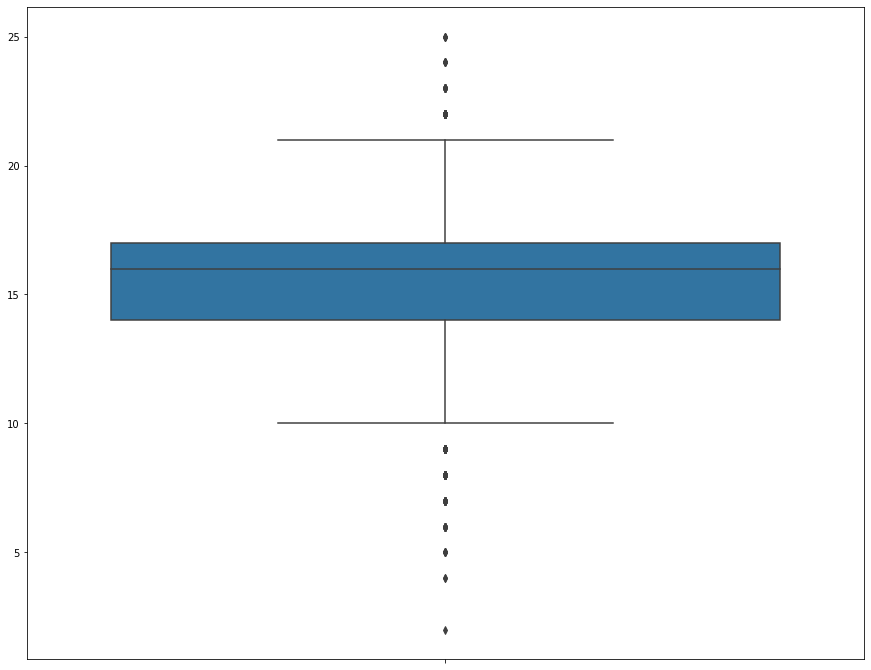

In [21]:
docs_lengths = [len(document) for document in tokenized_tweets]

fig, ax = plt.subplots(figsize=(15, 12))


sns.boxplot(y=docs_lengths, ax=ax)

plt.show()

In [22]:
max_length = int(np.percentile(a=docs_lengths, q=98))
pad_idx = tokenizer.vocab.get('[PAD]')

One approach to creating padded sequences is:
1. Create the output matrix as all padding
2. Limit documents with length greater than `max_length`
3. Replace the padding vectors with real token vectors whenever found


In [23]:
# Step 1
ohe_seq = np.zeros((num_samples, max_length, vocab_size))
ohe_seq[:, :, pad_idx] = 1


In [24]:
for doc_index, document in enumerate(tokenized_tweets):
    
    # Step 2
    document = document if len(document) <= max_length else document[0:max_length]
    
    # Step 3
    for token_order, token in enumerate(document):
        ohe_seq[doc_index, token_order, pad_idx] = 0
        ohe_seq[doc_index, token_order, token] = 1

In [25]:
ohe_seq.shape

(4000, 21, 7755)

## One Hot Encoding Exercise

Perform one hot encoding with a third party library

Suggestions: 

- [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

- [torchtext](https://pytorch.org/text/stable/index.html)

In [26]:
encoder = OneHotEncoder()

NameError: name 'OneHotEncoder' is not defined

In [ ]:
encoder.fit(tokenized_tweets)

In [ ]:
from typing import Union, Iterable
import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

corpus = ["The cat sat the mat", "The dog ate my homework"]
tokenizer = get_tokenizer("basic_english")
tokens = [tokenizer(doc) for doc in corpus]

voc = build_vocab_from_iterator(tokens)

def my_one_hot(voc, keys: Union[str, Iterable]):
    if isinstance(keys, str):
        keys = [keys]
    return F.one_hot(torch.tensor(voc(keys)), num_classes=len(voc))
my_one_hot(tokens,corpus)

## TF-IDF (Exercise)

Steps:
1. For the corpus calculate document frequency for each token (DF)
2. For the corpus calculate inverse of document frequency for each token (IDF)
3. For each document calculate term frequency (TF) for each token
4. Calculate TF-IDF

Desired output shape: `[num_samples, vocab_size]`

In [99]:
#Importing required module
import numpy as np
from nltk.tokenize import  word_tokenize 

class TfIdfVectorizer:
    def __init__(self,corpus):
        self.corpus=corpus
        self.vectors=[]
        self.sentences=[]
        self.word_set=[]
        self.total_documents = len(self.corpus)
        self.tokeniz()
        self.index_dict = {}
        self.word_set = set(self.word_set )
        self.create_vocab()
    def tokeniz(self):
        for sent in self.corpus:
            print(sent)
            x = [i.lower() for  i in word_tokenize(sent) if i.isalpha()]
            self.sentences.append(x)
            for word in x:
                if word not in self.word_set:
                    self.word_set.append(word)
    def create_vocab(self):
        #Creating an index for each word in our vocab.
        i = 0
        for word in self.word_set:
            self.index_dict[word] = i
            i += 1 
    def count_dict(sentences):
        word_count = {}
        for word in self.word_set:
            word_count[word] = 0
            for sent in sentences:
                print("--",end="")
                print(sent)
                if word in sent:
                    word_count[word] += 1
        return word_count

    #Term Frequency
    def termfreq(self,document, word):
        N = len(document)
        occurance = len([token for token in document if token == word])
        return occurance/N
    #Inverse Document Frequency
    def inverse_doc_freq(self,word):
        try:
            word_occurance = word_count[word] + 1
        except:
            word_occurance = 1
        return np.log(self.total_documents/word_occurance)
    
    def tf_idf(self,sentence):
        print(sentence)
        tf_idf_vec = np.zeros((len(self.word_set),))
        for word in sentence:
            tf = self.termfreq(sentence,word)
            idf = self.inverse_doc_freq(word)
            value = tf*idf
            tf_idf_vec[self.index_dict[word]] = value 
        return tf_idf_vec
    def fit(self):
        #TF-IDF Encoded text corpus
        for sent in self.sentences:
            print(sent)
            vec = self.tf_idf(sent)
            self.vectors.append(vec)


In [100]:
lst=[
"Welcome in our session ",
    "this session is about programming in our session ",
    "my pc is good ",
]

In [101]:
objtfidf=TfIdfVectorizer(lst)

Welcome in our session 
this session is about programming in our session 
my pc is good 


In [102]:
objtfidf.fit()


['welcome', 'in', 'our', 'session']
['welcome', 'in', 'our', 'session']
['this', 'session', 'is', 'about', 'programming', 'in', 'our', 'session']
['this', 'session', 'is', 'about', 'programming', 'in', 'our', 'session']
['my', 'pc', 'is', 'good']
['my', 'pc', 'is', 'good']
